# SLU11 - Tree-based models: Learning notebook

In [1]:
from math import log2

import pandas as pd
import numpy as np

from sklearn.datasets import fetch_california_housing
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from IPython.display import Image

import utils

## 1. Decision trees

A **decision tree** is a decision support tool in the form of a tree-like structure. It can be used for classification or regression. It's most commonly used for classification, where each node is associated with a test on a feature, each branch represents an outcome of the test, and each leaf the final decision.

In order to explain how decision trees work, let's use an example based on the weather we'd like to go hiking, which can be represented in the simple decision tree below: 

<img src="media/simple-decision-tree.png" alt="simple-decision-tree" style="width: 600px;"/>

*Fig. 1: A simple decision-tree used for classification ([Quinlan, 1986](http://hunch.net/~coms-4771/quinlan.pdf)).*

This decision tree represents a flow of conditional statements (i.e., `if Condition then Outcome`) where:

* Each **node** represents a test of a feature (e.g., is it windy?)
* Each **branch** represents the outcome of the test (e.g., as true or false)
* Each **leaf** represents the outcome of decision (represented with N and P for negative and positive).

The paths from **root** to leaf represent rules the flow the statements follow, e.g., `if the outlook is sunny and humidity is normal, then go hiking`.

### 1.1 Learning sets of rules as decision trees

Typically, a decision tree is developed from the top to the bottom (known as top-down induction), and there are several algorithms that can be used to build them, including
* **Iterative Dichotomiser 3 (ID3)**, for classification using categorical features (use of entropy and information gain as metric.)
* **C4.5**, a successor to ID3 that supports non-categorical features
* **Classification and Regression Trees (CART)**, generalizes C4.5 to support regression (use of Gini impurity as the metric).

We follow ID3 ([Quinlan, 1986][1]) for binary classification using categorical features with a small set of possible values (i.e. low cardinality).

[1]: http://hunch.net/~coms-4771/quinlan.pdf "Quinlan, J. 1986. Induction of Decision Trees. Machine Learning 1: 81-106."

In [2]:
data = utils.make_data()

#### 1.1.1 Algorithm overview

Take an arbitrary training set $C = \{\textbf{x}_i, y_i\}_{i=1}^m$, a collection of labeled observations, with $y_i \in \{L_1, \dots, L_v\}$.

The features vector is represented as $\textbf{x}_i = \{x_i^{(1)}, \dots, x_i^{(n)}\}$, where $x_i^{(j)}$ is the value of the $j$-th feature for the $i$-th observation.

In ID3, $x_i^{(j)}$ can take on one of a fixed number of possible values $x_i^{(j)} \in \{A_1^{(j)}, \dots, A_w^{(j)}\}$.

$$X = \begin{bmatrix}
  x_1^{(1)} & x_1^{(2)} & \dots & x_1^{(n)} \\
  x_2^{(1)} & x_2^{(2)} & \dots & x_2^{(n)} \\
  \dots     & \dots     & \dots & \dots     \\
  x_m^{(1)} & x_m^{(2)} & \dots & x_m^{(n)}
 \end{bmatrix}$$

These are the features of our data set: 

In [3]:
X, y = utils.separate_target_variable(data)

X

,Outlook,Temperature,Humidity,Windy
0,sunny,hot,high,false
1,sunny,hot,high,true
2,overcast,hot,high,false
3,rain,mild,high,false
4,rain,cool,normal,false
5,rain,cool,normal,false
6,overcast,cool,normal,false
7,sunny,mild,high,false
8,sunny,cool,normal,false
9,rain,mild,normal,false


This is a binary classification problem, where $y_i \in \{0, 1\}.$

$$y = \begin{bmatrix}
  y_1   \\
  y_2   \\
  \dots \\
  y_3 
 \end{bmatrix}$$

These are the labels of our dataset: 

In [4]:
y

0     0
1     0
2     1
3     1
4     1
5     0
6     1
7     0
8     1
9     1
10    1
11    1
12    1
13    0
Name: Class, dtype: int64

Now, imagine a test $T$ on the feature $x_i$ with possible outcomes $O_1, O_2, \dots, O_w$. 

It can be a condition on the feature values, for example.

The test $T$ produces a partition (division of observations into groups) $\{C_1, C_2, \dots, C_w\}$ of $C$ where $C_k$ contains the observations having the outcome $O_k$.

<img src="media/test-partitioning.png" alt="test_partitioning" style="width: 600px;"/>

*Fig. 2: Partitioning of the objects in $C$ with a test $T$ ([Quinlan, 1986](http://hunch.net/~coms-4771/quinlan.pdf)).*

We can recursively apply different tests to each of these partitions creating smaller and smaller sub-partitions until we get homogenous (i.e., single-class) leaves. The result of this process is a decision tree for all $C$.

This tree-building algorithm can be described in the following way:
```
ID3 (Data, Target, Attributes)
    If all examples are positive, Return a single-node tree Root, with label = 1.
    If all examples are negative, Return a single-node tree Root, with label = 0.
    Otherwise Begin
        A <- Pick the Attribute that best classifies examples.
        Decision tree for Root = A.
        For each possible value, O_i, of A,
            Add a new tree branch, corresponding to the test A = O_i.
            Let Data(v_i) be the subset of examples that have the value O_i for A.
            Below this new branch add the subtree ID3 (Data(O_i), Target, Attributes – {A}).
    End
    Return Root
```


But what is the **attribute that best classifies examples** at each step? As we will soon see, this is related with the concepts of **information gain** and **entropy**.

### 1.2 Attribute selection

A test has a high **information gain** if it generates partitions with low [entropy](https://en.wikipedia.org/wiki/Entropy_(information_theory)). In general, the greater the homogeneity of a partition, the lower its entropy.

In this case, a partition is said to be very homogeneous if the majority of its elements belong to a single class. 

Consider the problem of binary classification (it can be extended to support multi-class settings). Take $p$ as the probability of the positive class, i.e., the proportion of positive cases in the set. In this case, the entropy is given by:

$$I(p) = - p \log_2 p - (1 - p) \log_2 (1-p)$$

It ranges between 0 and 1:

* 0, when $p=1$ or $p=0$. We are in a situation of low entropy/high purity, because there is no "surprise" in the outcome: all samples belong to the same class. We say the information is minimum, because observing the class of an instance will not give us any new information. We already know what it will be. 
* 1, when $p=\frac{1}{2}$. We are in a situation of high entropy/low purity, because the "uncertainty" of the outcome is maximum. Everytime we pull out an observation, it can be of positive or negative class with equal probability. This is equivalent to saying that the information is maximum.

Incidentally, entropy is measured in **bits** (hence the $log_2$ in the formula, since it tells you the number of digits you would need to represent a number in base 2).

The following function calculates entropy for the given probability of positive class:

In [5]:
def entropy(p):
    if 0 < p < 1:
        return -p * log2(p) - (1 - p) * log2(1 - p)
    else:
        return 0

Let's compute the entropy for our data set. First, we compute the probability of the positive class:

In [6]:
def compute_probability(data):
    n = data.shape[0]
    f = (data['Class'] == 1).sum()

    return f / n


p = compute_probability(data)
print(p)

0.6428571428571429


Using this probability, we get the entropy:

In [7]:
print(entropy(p))

0.9402859586706311


We have a fairly high entropy for the entire data set.

This means that the data is distributed fairly uniformly between the classes, as already indicated by the probability of the positive class $p$. The data is not homogenous.

Starting from a set with high entropy, we would like to design a test that divides it into partitions that are as homogeneous as possible. In an ideal case, each partition would be a leaf node containing only instances from a single class.

A test is restricted to branching on one attribute $A$ with values $\{A_1, A_2, \dots, A_v\}$, thus partitioning $C$ into $\{C_1, C_2, \dots, C_v\}$. 

The expected entropy of the test is obtained as the weighted average of the entropy of the resulting groupings:

$$E(A) = \sum_{i=1}^v \frac{\|C_i\|}{\|C\|}I(p_i)$$

In short and as expected, we are measuring an attribute's ability to generate homogeneous groupings.

Let's calculate the expected entropy of the `Outlook` feature:

In [8]:
def mean_entropy(data, attribute):
    c_norm = data.shape[0]
    information = 0
    values = data[attribute].unique()
    for value in values:
        group = data[data[attribute] == value]
        
        c_i_norm = group.shape[0]
        
        w = c_i_norm / c_norm
        
        p = compute_probability(group)
        e = entropy(p)
    
        information += w * e
    
    return information

print(mean_entropy(data, 'Outlook'))

0.6935361388961918


Given this result, the `Outlook` feature yields partitions that have, on average, a much lower entropy than the entire data set. It is a good candidate for the first test (first node - the root!).

We call this loss of entropy the **information gain** of branching on attribute $A$, and it is given by:

$$IG(A) = I(p) - E(A)$$

where $I(p)$ is the entropy on the node over which the test is being performed, and $E(A)$ is the expected entropy of the test.

Let's compute it.

In [9]:
def information_gain(data, attribute):
    p = compute_probability(data)
    i = entropy(p)
    
    e = mean_entropy(data, attribute)
    
    return i - e


print(information_gain(data, 'Outlook'))

0.24674981977443933


To generate the simplest possible tree, it is a good choice to branch, at each step, on the attribute with the highest information gain. Let's calculate the information gain for all attributes:

In [10]:
def examine_candidate_attributes(data, attributes):
    return {
        attribute:information_gain(data, attribute) 
        for attribute 
        in attributes
    }


attributes = [c for c in data.columns if c != 'Class']
pd.Series(examine_candidate_attributes(data, attributes)) # converting to pd.Series just for pretty printing

Outlook        0.246750
Temperature    0.029223
Humidity       0.151836
Windy          0.025078
dtype: float64

`Outlook` was a good choice, so we can start the branching here. The tree will have a branch for each value of this attribute.

In [11]:
outlook_values = data['Outlook'].unique()
outlook_values

array(['sunny', 'overcast', 'rain'], dtype=object)

We repeat the process in each partition generated by the `Outlook` attribute to determine on which attribute we should branch next.

In [12]:
for i, value in enumerate(outlook_values):
    partition = data[data['Outlook'] == value]
    results = examine_candidate_attributes(partition, attributes)
    print("\n---\n")
    print("Partition: Outlook == {}. \nResults:\n{}.".format(value, pd.Series(results)))


---

Partition: Outlook == sunny. 
Results:
Outlook        0.000000
Temperature    0.570951
Humidity       0.970951
Windy          0.019973
dtype: float64.

---

Partition: Outlook == overcast. 
Results:
Outlook        0.0
Temperature    0.0
Humidity       0.0
Windy          0.0
dtype: float64.

---

Partition: Outlook == rain. 
Results:
Outlook        0.000000
Temperature    0.019973
Humidity       0.019973
Windy          0.321928
dtype: float64.


Interestingly enough, none of the attributes provides information gain in the `Outlook == overcast` case. Let's look at this subset and try to understand why.

In [13]:
data[data['Outlook'] == 'overcast']

,Outlook,Temperature,Humidity,Windy,Class
2,overcast,hot,high,false,1
6,overcast,cool,normal,false,1
11,overcast,mild,high,true,1
12,overcast,hot,normal,false,1


As it turns out, this grouping is already homogeneous (all instances are positive): that means it's already a leaf, which means we have our first rule:

```
If the outlook is overcast, then Go Hiking.
```

We now continue partitioning recursively until all the resulting groupings are homogeneous (we obtain pure leaves) or until we have exhausted our features (in which case, we assign to the final leaves the majority class in their partition). The resulting tree is shown in the next section. You can do the information gain calculations as an exercise if you like.

### 1.3 Using decision trees

The `sklearn` implementation uses an optimized version of the CART algorithm. This means that the resulting decision tree might be different than if you had used ID3. 

We won't go into this in detail, but don't worry. The principles behind it are very similar to what you've learned already.

In [14]:
X_ = utils.process_categorical_features(X)

clf = DecisionTreeClassifier(criterion='entropy', random_state=101)
print(clf.fit(X_, y))

DecisionTreeClassifier(criterion='entropy', random_state=101)


In the code block above, we use a trick to convert categorical variables into something more `sklearn`-friendly.

(Ignore it for now. You'll learn all about it in due time in the SLU12.)

Then, we train a `DecisionTreeClassifier` (refer to the [docs](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) for more information).

Let's visualize the resulting tree:

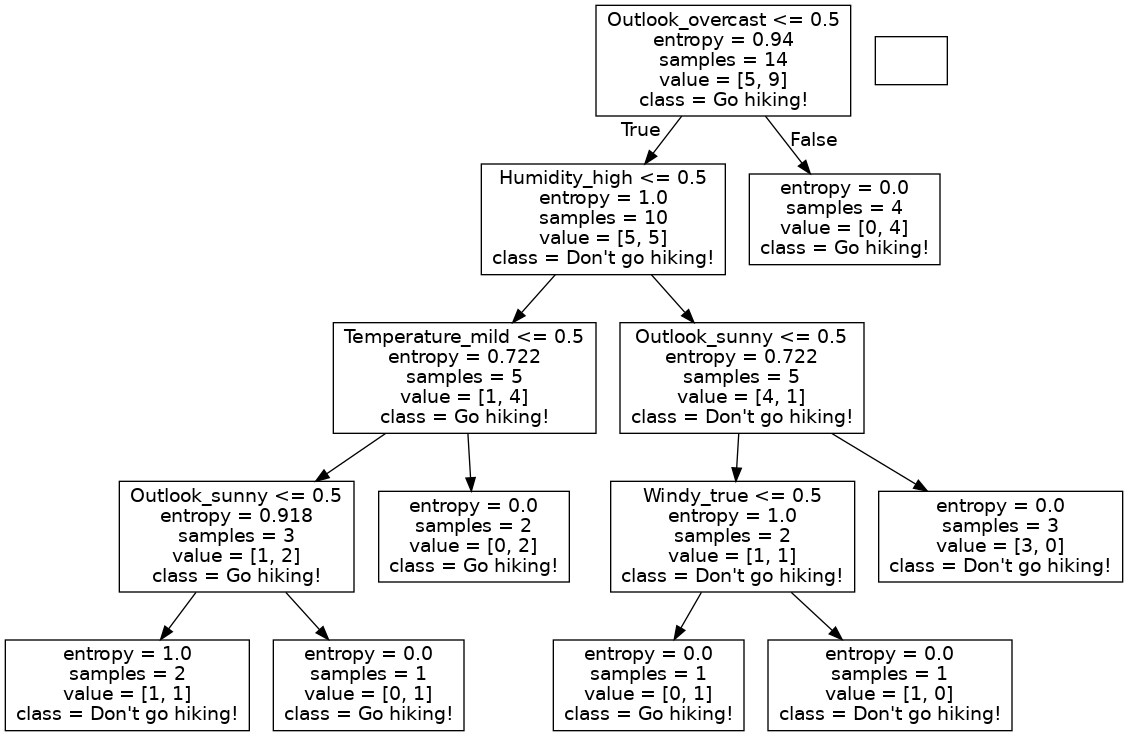

In [15]:
class_names = ["Don't go hiking!", "Go hiking!"]
t = utils.visualize_tree(clf, X_.columns, class_names)
Image(t)

This tree is a bit different than the schema we saw in section 1. In the schematic tree, we split each node on one attribute, with branches representing all possible values of that attribute. The question regarding the first node was "*how is the outlook?*". 

This tree is built with recursive binary splitting. Each decision is a *Yes* or *No* question, e.g., "*Is the outlook overcast or not?*". On each node, we can see the following:

* Two different paths, indicated by each result of the test `(attribute_value <= 0.5)` applied to the current node. `True` means **all instances in this node for which the `attribute` IS NOT equal to the `value`**. The left path is always true, and the right path is always false.
* The entropy in that node.
* The `value` array, which indicates how many samples reaching that node belong to each class (the classes are in ascending numerical order).
* The name of the majority class in the node (in case of a tie, the first class in numerical order is taken).

The CART algorithm can also be used for regression problems. In that case, you should use the `DecisionTreeRegressor` (refer to the [docs](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html)). To visualize a simple example, check out [this page](https://scikit-learn.org/stable/auto_examples/tree/plot_tree_regression.html).

### 1.4 Feature importance

A great characteristic of decision trees is that they allow us to compute **feature importance**: a score for each feature based on how useful it is at predicting the target variable. Note that a feature in this decision tree is actually an attribute-value pair, e.g., *overcast outlook* or *high humidity*.

The importance of a feature is given by the decrease in node impurity (according to the criterion being used. In this case, the entropy.), weighted by the proportion of samples reaching the node.

The `DecisionTreeClassifier` calculates the importance of features for us. We print them here in descending order:

In [16]:
feature_importances = pd.Series(data=clf.feature_importances_, index=X_.columns)
feature_importances.sort_values(ascending=False)

Outlook_overcast    0.283411
Humidity_high       0.249079
Outlook_sunny       0.211799
Windy_true          0.179147
Temperature_mild    0.076563
Outlook_rain        0.000000
Temperature_cool    0.000000
Temperature_hot     0.000000
Humidity_normal     0.000000
Windy_false         0.000000
dtype: float64

Clearly, the unused features have zero feature importance.

By inspecting the visual representation of the tree, we can see that the `Windy_true` attribute has the highest information gain (from 1 to 0 on both leaves it generates), and therefore the highest decrease in node impurity. 

However, few samples match that node (only 2 in the training set). That means this is not the most important feature, since it's not as relevant to predicting the class in the overall dataset. Compare it with the feature with the highest importance, `Outlook_overcast`, placed right at the root of the tree. Despite the fact that it doesn't have high information gain, it immediately allows us to classify four samples as "Go Hiking".

### 1.5 Pros and cons of decision trees

#### 1.5.1 Pros

Decision trees are a straightforward way to represent rules that

* are simple to understand, interpret, and visualize
* require little to no data preparation (for example, don't require data scaling and normalization)
* are able to handle numerical and categorical variables
* are missing values in the data that don't affect (to a large extent) the process of building the tree
* are a white-box model, wherein all decisions are replicable and easily explicable.

#### 1.5.2 Cons

Decision trees' extreme flexiblity make them prone to creating overly complex trees that
* due small changes in the data, can cause a large changes in the structure of the decision tree, thereby causing instability
* usually take longer to train (leading to an increase in price as the complexity and time increase)
* prone to overfitting
* prone to overfitting!
* **prone to overfitting!**

(Repetition makes perfect.)

Mechanisms, such as pruning (removing sections of the tree) and setting the maximum depth of the tree, help reduce overfitting. Let's see how we can configure the maximum tree depth with `sklearn`:

In [17]:
clf = DecisionTreeClassifier(
    criterion='entropy', 
    max_depth=2, 
    random_state=101
)
print(clf.fit(X_, y))

DecisionTreeClassifier(criterion='entropy', max_depth=2, random_state=101)


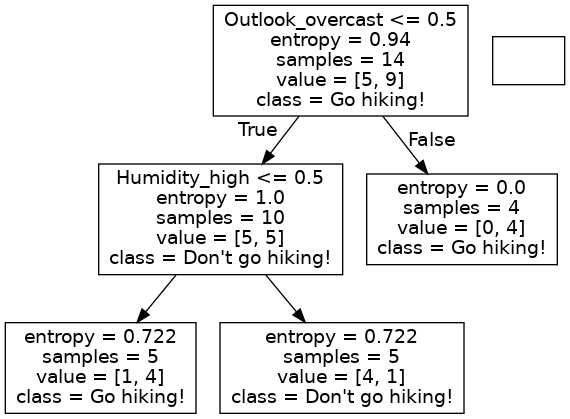

In [18]:
t = utils.visualize_tree(clf, X_.columns, class_names)
Image(t)

We can also set the minimum number of samples required to split a node to avoid fully-grown trees.

In [19]:
clf = DecisionTreeClassifier(
    criterion='entropy', 
    min_samples_split=5, 
    random_state=101
)
print(clf.fit(X_, y))

DecisionTreeClassifier(criterion='entropy', min_samples_split=5,
                       random_state=101)


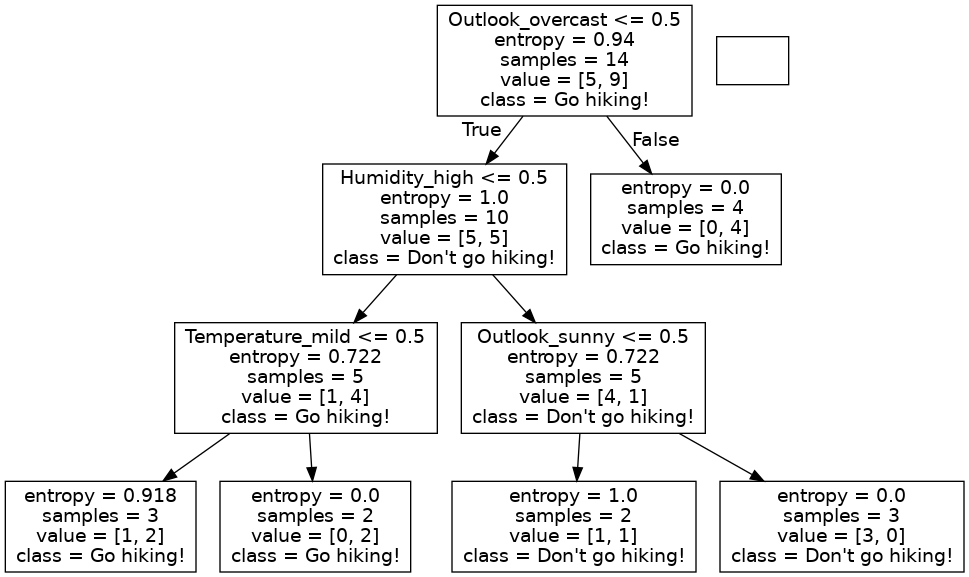

In [20]:
t = utils.visualize_tree(clf, X_.columns, class_names)
Image(t)

Some final notes:

* If the attributes are adequate, it is always possible to construct a decision-tree that correctly classifies every training instance.
* Attributes are **inadequate** if the data contains two objects that have identical values for each attribute, and yet belong to different classes.
* The key takeaway: **decision trees overfit like hell**.

These help control overfitting, but they might not be adequate. In fact, sometimes this approach is too heavy-handed, and it might lead to underfitting. We'll need to find a smarter way to control overfitting, while, at the same time, allowing our trees to represent complex rules.

### 1.6 Tree-based ensembles

One answer to overfitting are **ensemble methods**, which combine the predictions of several models, known as **base learners** or **base estimators**. Each individual estimator in the ensemble is often a "weak learner", i.e., it has slightly better accuracy than random values. However, by combining the predictions of the entire ensemble, we often get better results that are less prone to overfitting when compared to using a single, larger model.

<img src="media/ensemble-methods.png" alt="ensemble-methods" style="width: 600px;"/>

*Fig. 3: A simple ensemble model using many trained models to generate a single prediction.*

Ensembles can be homogeneous or heterogenous depending on whether the base learners are the same type or not.

We focus in particular on homogenous ensembles of decision-trees because we want to reduce

* their variance (i.e., **bagging**) by building several independent trees and then calculating the average of their predictions.
* the bias of the combined estimator (i.e., **boosting**) by building trees sequentially.

## 2. Bagging with random forests

Bootstrap aggregating, also known as bagging, consists of the following:

1. Creating several independent data sets.
2. Training a model in each data set.
3. Aggregating individual predictions.

Bagging can be seen as training several independent models in parallel and averaging the predictions.

Imagine the following example. You have a strange feeling in your nose and want a diagnosis. You have the option of going to a single, extremely-specialized podiatrist -- that's a foot doctor, in case you didn't know -- which in this analogy represents a single large model, or you could get your diagnosis from 500, 3rd year university medical students working together, which in this analogy represents a bag of simpler, shallower models.

Now, the podiatrist is very specialized. One might even say that they are **overfit** to foot diseases. They might be able to extend their knowledge to your particular affliction and give a good diagnosis, but odds are that they'll be wrong. 

The medical students, on the other hand, might lack individual expertise, but their collective understanding is likely to lead to a better diagnosis than the podiatrist's. This is because, as a group, the students are likely to have exposure to more areas in medicine than one expert individual, the podiatrist, will have. 

This example illustrates the main strength of bagging, which is that several weak models can cancel each other's weaknesses provided that they are highly independent and were exposed to different information. 

But how does this relate to decision trees, you might ask? Well, decision trees don't just overfit. They're also highly unstable: small variations in the data can result in wildly different trees.

This makes them particularly suited for bagging.

### 2.1 Bagging

Suppose you have a sequence of data sets, $\{D_1, D_2, \dots, D_k\}$, with observations from the same underlying distribution $\mathcal{D}$.

We can obtain an **ensemble of models**, $\{h_1, h_2, \dots, h_k\}$, by training a model in each data set.

<img src="media/bagging-estimator.png" alt="bagging-estimator" style="width: 600px;"/>

*Fig. 4: In bagging, different data sets are generated from the main one, and models are trained in parallel and predictions averaged.*

By running the models in parallel, we get a list of predictions from our ensemble, $\{\hat{y}_1\, \hat{y}_2\, \dots, \hat{y}_k\}$.

To obtain a single prediction, we can evaluate all models and aggregate the results:
* We calculate the average of the $k$ predictions (regression).
* We use majority voting to predict a class (classification).

More often than not, however, we don't have multiple data sets. In this situation, we can use bootstrapping.

### 2.2 Bootstrapping

Let's take random samples by replacing $\{C^1, C^2, \dots, C^b\}$ from $C$, our full dataset:

In [21]:
def make_bootstrap_data(data, b):
    n = data.shape[0]
    return [data.sample(n=n, replace=True) for i in range(b)]

bootstrap_data = make_bootstrap_data(data, 2)

Typically, bootstrapped data sets are the same size as the original data set.

In [22]:
bootstrap_data[0]

,Outlook,Temperature,Humidity,Windy,Class
13,rain,mild,high,true,0
9,rain,mild,normal,false,1
1,sunny,hot,high,true,0
11,overcast,mild,high,true,1
3,rain,mild,high,false,1
11,overcast,mild,high,true,1
9,rain,mild,normal,false,1
8,sunny,cool,normal,false,1
12,overcast,hot,normal,false,1
0,sunny,hot,high,false,0


In [23]:
bootstrap_data[1]

,Outlook,Temperature,Humidity,Windy,Class
1,sunny,hot,high,true,0
7,sunny,mild,high,false,0
6,overcast,cool,normal,false,1
13,rain,mild,high,true,0
9,rain,mild,normal,false,1
11,overcast,mild,high,true,1
4,rain,cool,normal,false,1
11,overcast,mild,high,true,1
0,sunny,hot,high,false,0
5,rain,cool,normal,false,0


We would now train a different decision tree on each data set and use voting to predict whether or not to go hiking.

Bagging works very well to control overfitting and reduce generalization errors in unstable models. If one of the models in the bag overfits to a certain noisy observation, it's likely that its vote will be drowned out by the rest of the models in the ensemble.

### 2.3 Random forests

A **random forest** is an ensemble learning method created by bagging multiple decision trees. Bagging is then used in tandem with random feature selection:

* Datasets are generated from original data using bootstrapping (row sampling).
* Then, a tree is grown on each bootstrapped data set using random feature selection (column sampling).

Random feature selection means that only a random subset of the features is available at each split.

Randomizing features acts as a kind of regularization. It mitigates overfitting, because it forces each individual classifier to be as good as possible, while having access to limited information. This increases diversity inside the ensemble, which is often beneficial.

Fortunately, `sklearn` implements all this intricate logic for us.

In [24]:
rf = RandomForestClassifier(
    n_estimators=10, 
    criterion='entropy',
    max_features=2, 
    bootstrap=True
)

print(rf.fit(X_, y))

RandomForestClassifier(criterion='entropy', max_features=2, n_estimators=10)


For detailed information about the models, check this documentation:
* RandomForestClassifier ([docs](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html))
* RandomForestRegressor ([docs](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)).

Bagging is a great technique to reduce overfitting and the variance of our final predictions. This comes at the cost of interpretability: it's much easier to interpret the rules contained within a single decision tree than it is to analyze the driving forces in a majority vote of hundreds or even thousands of models. 

## 3. Boosting with gradient boosting

**Boosting** is a different ensemble learning technique. Instead of training several base learners in parallel and averaging their predictions, boosting trains them sequentially, and the input of each model becomes the residual error of the previous model.

The general idea is to build strong ensembles by combining base learners sequentially, each of which corrects previous errors and therefore reduces bias.

**Note:** this section can be pretty intimidating at first, but don't despair! It will be worth it in the end.

### 3.1 Boosting

Trees are grown sequentially, and each tree is created using information derived from a previous tree. In each iteration,

1. errors and misclassifications of the past model are given increased weight in the new training data set.
2. the current model is then trained on the new training set, which fits the residual errors of the previous model.

As a result, each model specializes in correcting past mistakes and misclassifications. 

<img src="media/boosting-estimator.png" alt="boosting-estimator" style="width: 600px;"/>

As a result, this produces an ensemble of models that are effetive in different "parts" of the training data, as they sequentially correct each other's mistakes. The final prediction is obtained by summing the predictions of each model in the ensemble.

Boosting is less robust than bagging against overfitting, and, as such, boosting is recommended to control the number of estimators used, the strength of each estimator, the learning rate, and use other regularization techniques.

In this example, we will use the [california](https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html) house-prices data set (regression).

In [25]:
def prepare_california():
    california = fetch_california_housing()
    X = pd.DataFrame(data=california.data, columns=california.feature_names)
    y = pd.Series(data=california.target, name='price')
    
    return X, y

X_california, y_california = prepare_california()

### 3.2 What do we mean by "gradient" boosting

To understand the meaning of **gradient boosting**, we need to review a couple of concepts.

#### 3.2.1 Loss function

A loss function quantifies how bad our predictions are. An example of this is the squared error:

$$L_i = (y_i - \hat{y}_i)^2$$ 

As we can see, the squared error increases with the square of the difference between the prediction and the real value. The worse this error becomes across all data samples, the worse it will be for the overall performance of the model.

Training an individual machine learning model aims at minimizing of the total loss over all observations in the training set. With respect to the model's parameters $\theta$: 

$$\min_{\theta} J = \sum_{i=1}^N L(y_i, \hat{y}(x_i, \theta))$$

where $\hat{y}_i=\hat{y}(x_i, \theta)$ are the model's predictions.

#### 3.2.2 Gradient descent

The geometrical meaning of the gradient of a loss function ($\nabla$) is its inclination or slope at each point.

This is a fancy term for the multi-variable generalization of the derivative, i.e., the partial derivatives of function $f$ at a given point.

When training a model by gradient descent, we calculate, at each training step, the derivative of the loss $L$ with respect to the model's parameters and then update the parameters by giving a small step in the opposite direction of this gradient: the direction in which the loss is decreasing:

$$\theta^{n+1} = \theta^{n} - \eta \nabla_{\theta} L(y, \hat{y})$$

At each step, we try to move our model gradually to a location in parameter space where the loss function has a lower value.

### 3.3 Gradient boosting in detail

We now have all the pieces required to understand gradient boosting. Let's consider the case of a numerical target variable.

We have our first model in the boosting ensemble, $F^{(1)}(X, \theta)$, which achieves a certain loss given by $L(\textbf{y}, F^{(1)}(\vec{x}, \theta))$. That means that for every sample, there is a difference between the model output $\hat{y}_i$ and the target $y_i$.

We now want to add a second model, $h$, to improve our first. For every sample, the prediction of the second model should fill the gap between the target and the first prediction: 

$$F^{(1)}(x_1) + h(x_1) = y_1$$
$$F^{(1)}(x_2) + h(x_2) = y_2$$
$$...$$

or equivalently, the prediction of the second model should be equal to the error or residual of the first model, the difference between the target and the first prediction

$$h(x_1) = y_1 - F^{(1)}(x_1)$$
$$h(x_2) = y_2 - F^{(1)}(x_2)$$
$$...$$

So we want to fit the second model to this set of sample features and targets:

$$(x_1, y_1 - F^{(1)}(x_1))$$
$$(x_2, y_2 - F^{(1)}(x_2))$$
$$...$$

As we already mentioned, $y_i - F^{(1)}(x_i)$ are the errors or **residuals**. The role of $h$ is to try to compensate for the weaknesses of the initial model. If the second model $F^{(2)} = F^{(1)} + h$ isn't good enough, meaning that the combined prediction $F^{(1)}(x) + h{x}$ doesn't reach the target, we can fit an additional regression tree to its residuals, and so on and so forth.

Returning to our first model, recall that we used the squared error loss function:

$$ L(\vec{y},F_1(x)) = (\vec{y} - F^{(1)}(X))^2 = \sum_i{L(y_i, F^{(1)}(x_i))} $$

We want to minimize $J = L(\vec{y},F_1(X))$ by adjusting $F^{(1)}(x_1)$, $F^{(1)}(x_2)$, ...

Now, what we're actually adjusting -- _during learning_ -- are the parameters $\theta$ of $F^{(1)}$, but if we take a functional perspective, we can observe that $F^{(1)}(x_i)$ are simply numbers. We can treat them as parameters and take derivatives. Each partial derivative becomes

$$
\begin{align}
\frac{\partial J}{\partial F^{(1)}(x_i)} & = \frac{\partial}{\partial F^{(1)}(x_i)} \sum_{j=0}^{n}{L(y_j, F^{(1)}(x_j))} \\
& = \frac{\partial}{\partial F^{(1)}(x_i)} L(y_i, F^{(1)}(x_i)) \\
& = \frac{\partial}{\partial F^{(1)}(x_i)}(y_i - F^{(1)}(x_i))^2 \\
& = -2 (y_i - F^{(1)}(x_i)) \\
& = -2*residuals
\end{align}
$$

As you may have noticed, when the loss function is the squared error, the residuals are proportional to the negative gradients of the loss function!

Thus arises the similarity with gradient descent:

$$
\begin{align}
F^{(2)}(x_i) & = F^{(1)}(x_i) + h(x_i) \\
& = F^{(1)}(x_i) + y_i - F^{(1)}(x_i) \\
& = F^{(1)}(x_i) - \frac{1}{2}\frac{\partial J}{\partial F^{(1)}(x_i)} \\
\end{align}
$$

This is how we get the next iteration of the model parameters:

$$
\theta^{n+1} = \theta^{n} - \eta \frac{\partial J}{\partial F(\theta_i)}
$$

To summarize for regression with **square loss**,

* the residual <=> negative gradient
* fitting $h$ to the residual <=> fitting $h$ to the negative gradient
* adding a new estimator based on the residual <=> adding a new estimator based on the negative gradient

When adding a new estimator to our boosting ensemble, we are actually minimizing a global loss function by using gradient descent, in function space!

The final thing to understand here is that the concept of gradients is more useful than the concept of residuals, because gradients allow us to generalize to loss functions other than the squared error. As long as we fit each additional model to the negative gradients of the current global model, we'll be minimizing our desired global loss function.

### 3.4 Gradient boosting in practice

Let's implement one step of the boosting algorithm. We'll use the mean squared error for the loss function, which is based on what we have discussed earlier!

#### 3.4.1 Initialization

We initialize all $F^{(1)}(x_i)$ to a sensible constant, $F^{(1)}(x_i) = \gamma$.

Since our goal is to minimize the mean squared error, we will use the mean value of the target variable in the training set.

In [26]:
y_california_h0_pred = np.repeat(y_california.mean(), y_california.size)

We compute the mean squared error of this initial set of predictions.

In [27]:
mean_squared_error(y_california, y_california_h0_pred)

1.3315503000818074

#### 3.4.2 Iterations

##### 3.4.2.1 Generate a new data set

We build a new training set at the start of each iteration by recomputing the target variable to be the gradient of the previous model.

More concretely, in the $j$-th iteration, we compute a new target variable, $r^{(j)}_i$, corresponding to the gradient of the past iteration:

$$r^{(j)}_{i} = \frac{\partial L(y_i, F^{(j-1)}(x_i))}{\partial F^{(j-1)}(x_i)} = -2(r^{(j-1)}_{i} - F^{(j-1)}(x_i))$$

For the first iteration,

* $r^{(j-1)}_i = y_i$, the original targets
* $F^{(j-1)}(x_i)) = F^{(1)}(x_i) = \gamma$

In [28]:
def compute_gradient(y, y_pred):
    return -2 * (y - y_pred)

y_california_h0_residual = compute_gradient(y_california, y_california_h0_pred)

##### 3.4.2.2 Train a decision-tree

We now fit a new decision-tree to the negative gradient that we just calculated, $r^{(j)}_i$:

In [29]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_california, y_california_h0_residual)

y_california_h0_residual_pred = dt.predict(X_california)

Typically, we will want to train the simplest, shallowest decision-trees as base learners to avoid overfitting, which is why we are setting the maximum depth of the tree to one.

##### 3.4.2.3 Update the global model

We now want to add the predictions made by this model (over the residuals) to the predictions made by the base model. The update rule goes as follows: where $\eta$ is a **learning rate** that controls the magnitude of the update and acts as a regularizer,

$$F^{(j)}(x_i)) = F^{(j-1)}(x_i)) - \eta \cdot \frac{\partial L(y_i, F^{(j-1)}(x_i))}{\partial F^{(j-1)}(x_i)}$$

The learning rate is also known as the *shrinkage factor*, as it shrinks the impact of the corrections of $\eta$ between 0 and 1.

Since we don't know the true value of $y_i$ at prediction time, we plug in the prediction of the decision tree we fit in the previous step:

$$F^{(j)}(x_i)) \approx F^{(j-1)}(x_i)) - \eta \cdot \hat{r}^{(j)}_i(x_i) $$

If everything goes well, we are moving, step-by-step, closer to the function that minimizes the squared error.

In [30]:
def update_predictions(previous_prediction, residual_prediction, lr):
    return previous_prediction - lr * residual_prediction

y_california_h1_pred = update_predictions(y_california_h0_pred, y_california_h0_residual_pred, lr=0.1)

Now, we compute the mean squared error for the updated predictions.

In [31]:
mean_squared_error(y_california, y_california_h1_pred)

1.1829598010492017

Hurrah! The error decreased. We continue the process until the error stops decreasing or until we detect signs of overfitting.

#### 3.4.3 Putting it all together

Suppose we have $m$ individual decision-trees (boosting stages).

The final prediction will be given by the sum of the initial constant and all the gradient-based corrections:

$$F^m_i(x_i) = \gamma + \sum_{j=1}^m \eta \cdot \hat{r}^{(j)}_i(x_i)$$

Where $\hat{r}^{(j)}_i(x_i)$ is the output of a decision-tree that predicts the negative gradient of the previous iteration.

A final note: don't worry if you didn't understand all the details of previous sections. It was quite heavy on the math. Just make sure you understand the basics of boosting and the idea behind it. `sklearn` has got you covered!


### 3.5 With sklearn

Enough with theory! `sklearn` to the rescue! Let's create a `GradientBoostingClassifier`, which can be used for classification problems:

In [32]:
gb = GradientBoostingClassifier(
    learning_rate=.1,
    n_estimators=10
)

print(gb.fit(X_, y))

GradientBoostingClassifier(n_estimators=10)


#### 3.5.1 Include sampling

Some implementations provide the ability to sample observations and features at each iteration, similar to what happens with random forests. Unsurprisingly, this reduces overfitting at the expense of increased bias.

In [33]:
gb = GradientBoostingClassifier(
    learning_rate=.1, 
    n_estimators=10, 
    subsample=.5
)
print(gb.fit(X_, y))

GradientBoostingClassifier(n_estimators=10, subsample=0.5)


## 4. Conclusion

You are now armed with the power of bagging and boosting, two techniques you can easily use to obtain models with a lot of expressive power that also generalize better! Hopefully, you also gained insight into the world of advanced machine learning techniques.

Make sure to review this notebook well, and, when you're ready, go solve the exercises. Good luck!